<img src="img/frontpage.png">

Photo by <a href="https://unsplash.com/de/@linalitvina?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Angelina Litvin</a> on <a href="https://unsplash.com/photos/K3uOmmlQmOo?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

<h1 style="font-size: 2.5em; background-color: #E0970D; padding: 1em">Problem Definition</h1>

This Notebook uses unsupervised machine learning methods to test two fairly widespread beliefs about the schools in, the capital of Norway, Oslo.

* The first belief is that schools located at traditionally richer the west side of Oslo provides a better education than schools on the east side.
* The second belief is that schools located in more immigrant dense areas of Oslo provides a relatively better environment for learning Math, Natural Sciences and English than Norwegian.

To test whether these beliefs are true, this notebook will make use of a publicly available dataset that comprises the final assessment grades received by the students at different secondary schools in Oslo (10th grade in Norway). The dataset covers six subjects: English, Mathematics, Natural Science, Norwegian oral, Norwegian primary language written and Norwegian secondary language written. The dataset can be downloaded by following this link: <a href="https://www.udir.no/tall-og-forskning/statistikk/statistikk-grunnskole/grunnskolekarakterer/?rapportsideKode=GSK_GSKarakterer&filtre=EierformID(-10)_EnhetID(-76_-17_-12)_FagID(31650_31663_31668_31670_31671_31672)_KaraktertypeID(1)_KjoennID(-10)_TidID(202206)_VisAntallPersoner(0)_VisKarakterfordeling(0)&radsti=F">link</a>. 

The analysis will be carried out using two types of clustering algorithms: kMeans and Hierarchical clustering.

In [1]:
import pandas as pd
import numpy as np
import requests

import json
import folium
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<h1 style="font-size: 2.5em; background-color: #E0970D; padding: 1em">Importing data</h1>

* The dataset is made available by the Norwegian Directorate for Education and Training and contains information about the final assessment grade received by pupils attending secondary school at the 10th grade level (according to the Norwegian system).
* The final assessment grade is given as an average of the grades received by the pupils at a particular school following a particular subject.
* This dataset is a subset of a wider dataset that contains only information about pupils attending school in the capital of Norway, Oslo, during the school year 2021-22.
* The dataset contains information about six subjects: English, Mathematics, Natural Science, Norwegian oral, Norwegian primary language written and Norwegian secondary language written.
* The three Norwegian subjects test different aspects of Norwegian mastery: Norwegian oral tests the ability to explain linguistical concepts verbally, Norwegian primary language tests the students' ability to express themselves in writing using the Norwegian standard “Bokmål” and Norwegian secondary language tests the students' ability to express themselves using the written standard “Nynorsk” (at least for most pupils).
* Some of the data is censored with the sign *. This is happening when there are a small number of pupils at the school that has received a grade in a subject.
* The data can be found following this <a href="https://www.udir.no/tall-og-forskning/statistikk/statistikk-grunnskole/grunnskolekarakterer/?rapportsideKode=GSK_GSKarakterer&filtre=EierformID(-10)_EnhetID(-76_-17_-12)_FagID(31650_31663_31668_31670_31671_31672)_KaraktertypeID(1)_KjoennID(-10)_TidID(202206)_VisAntallPersoner(0)_VisKarakterfordeling(0)&radsti=F">link</a>. 

In [2]:
df = pd.read_csv("data/Grunnskolekarakterer.csv", sep='\t', encoding='utf-16')

In [3]:
df

EnhetNivaa Vurderingsfagkode Nasjonaltkode  Fylkekode  Kommunekode  \
0             0           ENG0030          Alle          0            0   
1             1           ENG0030             I          0            0   
2             2           ENG0030             I          3            0   
3             3           ENG0030             I          3          301   
4             4           ENG0030             I          3          301   
..          ...               ...           ...        ...          ...   
400           4           NOR0220             I          3          301   
401           4           NOR0220             I          3          301   
402           4           NOR0220             I          3          301   
403           4           NOR0220             I          3          301   
404           4           NOR0220             I          3          301   

    Organisasjonsnummer            Vurderingsfagnavn    Nasjonalt  \
0                  Alle         Engelsk 10. årstrinn  Hele landet   
1                     I         Engelsk 10. årstrinn  Hele landet   
2                    03         Engelsk 10. årstrinn  Hele landet   
3                  0301         Engelsk 10. årstrinn  Hele landet   
4             974589648         Engelsk 10. årstrinn  Hele landet   
..                  ...                          ...          ...   
400           918399267  Norsk 10. årstrinn, muntlig  Hele landet   
401           913946065  Norsk 10. årstrinn, muntlig  Hele landet   
402           974590638  Norsk 10. årstrinn, muntlig  Hele landet   
403           976207130  Norsk 10. årstrinn, muntlig  Hele landet   
404           974590395  Norsk 10. årstrinn, muntlig  Hele landet   

           Fylke        Kommune         EnhetNavn  \
0    Alle fylker  Alle kommuner       Alle skoler   
1    Alle fylker  Alle kommuner       Hele landet   
2           Oslo  Alle kommuner              Oslo   
3           Oslo           Oslo              Oslo   
4           Oslo           Oslo     Abildsø skole   
..           ...            ...               ...   
400         Oslo           Oslo   Vollebekk skole   
401         Oslo           Oslo  Wang Ung Oslo AS   
402         Oslo           Oslo      Øraker skole   
403         Oslo           Oslo    Østmarka skole   
404         Oslo           Oslo      Årvoll skole   

    2021-22.Standpunkt.Alle eierformer.Alle kjønn.Snittkarakter  
0                                                  4,3           
1                                                  4,3           
2                                                  4,5           
3                                                  4,5           
4                                                  4,3           
..                                                 ...           
400                                                4,3           
401                                                4,9           
402                                                4,7           
403                                                4,7           
404                                                4,6           

[405 rows x 12 columns]

<h1 style="font-size: 2.5em; background-color: #E0970D; padding: 1em">Data cleaning</h1>

The dataset comes in a form that requires a considerable amount of data wrangling to make it ready for any type of analysis. In this section, we will carry out the following operations:

* Remove unnecessary aggregates (such as the municipal, county and country level)
* Remove unnecessary variables
* Translate Norwegian terms to English
* Remove schools with censored values.
* Change European decimal notation with ',' to American notation with '.'

In [4]:
# Remove unnecessary aggregates 
mask = df['EnhetNivaa'] == 4
df = df[mask]

In [5]:
# Remove unnecessary variables
df = df[ ['Vurderingsfagkode', 'Organisasjonsnummer', 'Vurderingsfagnavn', 'EnhetNavn', '2021-22.Standpunkt.Alle eierformer.Alle kjønn.Snittkarakter'] ]

In [6]:
# Translating Column names from Norwegian to English

translation_dict = {
    'Vurderingsfagkode': 'Subject Code',
    'Organisasjonsnummer': 'Organization Number',
    'Vurderingsfagnavn': 'Subject Name',
    'EnhetNavn': 'School Name',
    '2021-22.Standpunkt.Alle eierformer.Alle kjønn.Snittkarakter': 'Final Assessment Grade'
}

df = df.rename(columns = translation_dict)
df

Subject Code Organization Number                 Subject Name  \
4        ENG0030           974589648         Engelsk 10. årstrinn   
5        ENG0030           919233532         Engelsk 10. årstrinn   
6        ENG0030           982254701         Engelsk 10. årstrinn   
7        ENG0030           974589680         Engelsk 10. årstrinn   
8        ENG0030           980953602         Engelsk 10. årstrinn   
..           ...                 ...                          ...   
400      NOR0220           918399267  Norsk 10. årstrinn, muntlig   
401      NOR0220           913946065  Norsk 10. årstrinn, muntlig   
402      NOR0220           974590638  Norsk 10. årstrinn, muntlig   
403      NOR0220           976207130  Norsk 10. årstrinn, muntlig   
404      NOR0220           974590395  Norsk 10. årstrinn, muntlig   

                         School Name Final Assessment Grade  
4                      Abildsø skole                    4,3  
5    Akademiet realfagsskole Oslo AS                    4,6  
6                    Apalløkka skole                    4,2  
7                      Bjølsen skole                    4,3  
8             Bjørnholt ungdomsskole                    3,8  
..                               ...                    ...  
400                  Vollebekk skole                    4,3  
401                 Wang Ung Oslo AS                    4,9  
402                     Øraker skole                    4,7  
403                   Østmarka skole                    4,7  
404                     Årvoll skole                    4,6  

[381 rows x 5 columns]

In [7]:
# Translating Subject Name values from Norwegian to English

translation_dict = {
    'Engelsk 10. årstrinn': 'English', 
    'Matematikk 10. årstrinn': 'Mathematics',
    'Naturfag 10. årstrinn': 'Natural sciences', 
    'Norsk hovedmål 10. årstrinn, skriftlig': 'Norwegian primary language written',
    'Norsk sidemål 10. årstrinn, skriftlig': 'Norwegian secondary language written',
    'Norsk 10. årstrinn, muntlig': 'Norwegian oral'}

df['Subject Name'] = df['Subject Name'].map(translation_dict)

In [8]:
df

Subject Code Organization Number    Subject Name  \
4        ENG0030           974589648         English   
5        ENG0030           919233532         English   
6        ENG0030           982254701         English   
7        ENG0030           974589680         English   
8        ENG0030           980953602         English   
..           ...                 ...             ...   
400      NOR0220           918399267  Norwegian oral   
401      NOR0220           913946065  Norwegian oral   
402      NOR0220           974590638  Norwegian oral   
403      NOR0220           976207130  Norwegian oral   
404      NOR0220           974590395  Norwegian oral   

                         School Name Final Assessment Grade  
4                      Abildsø skole                    4,3  
5    Akademiet realfagsskole Oslo AS                    4,6  
6                    Apalløkka skole                    4,2  
7                      Bjølsen skole                    4,3  
8             Bjørnholt ungdomsskole                    3,8  
..                               ...                    ...  
400                  Vollebekk skole                    4,3  
401                 Wang Ung Oslo AS                    4,9  
402                     Øraker skole                    4,7  
403                   Østmarka skole                    4,7  
404                     Årvoll skole                    4,6  

[381 rows x 5 columns]

In [9]:
# Find schools with censored values for Final Assessment Grade
mask = df['Final Assessment Grade'] == '*'
df[mask]

Subject Code Organization Number                          Subject Name  \
30       ENG0030           899178092                               English   
46       ENG0030           974589885                               English   
62       ENG0030           974590654                               English   
114      MAT0015           974589885                           Mathematics   
130      MAT0015           974590654                           Mathematics   
131      MAT0015           973626361                           Mathematics   
172      NAT0021           974590786                      Natural sciences   
184      NAT0021           974589885                      Natural sciences   
200      NAT0021           974590654                      Natural sciences   
237      NOR0218           899178092    Norwegian primary language written   
252      NOR0218           974589885    Norwegian primary language written   
268      NOR0218           974590654    Norwegian primary language written   
303      NOR0219           899178092  Norwegian secondary language written   
326      NOR0219           973626434  Norwegian secondary language written   
358      NOR0220           974590549                        Norwegian oral   
383      NOR0220           974589885                        Norwegian oral   
399      NOR0220           974590654                        Norwegian oral   

                        School Name Final Assessment Grade  
30         Kuben videregående skole                      *  
46   Oslo voksenopplæring Skullerud                      *  
62                Vestre Aker skole                      *  
114  Oslo voksenopplæring Skullerud                      *  
130               Vestre Aker skole                      *  
131        Vetland skole grunnskole                      *  
172               Lønnebakken skole                      *  
184  Oslo voksenopplæring Skullerud                      *  
200               Vestre Aker skole                      *  
237        Kuben videregående skole                      *  
252  Oslo voksenopplæring Skullerud                      *  
268               Vestre Aker skole                      *  
303        Kuben videregående skole                      *  
326           Sollerudstranda skole                      *  
358                Haugenstua skole                      *  
383  Oslo voksenopplæring Skullerud                      *  
399               Vestre Aker skole                      *

In [10]:
# Remove Schools with missing values
delete_list = df[mask]['School Name'].unique()
mask_remove = df['School Name'].isin(delete_list)
df = df[~mask_remove]
df=df.dropna().reset_index(drop=True)

In [11]:
# Replacing European decimal sign with American.
df['Final Assessment Grade'] = df['Final Assessment Grade'].str.replace(',', '.')

<h1 style="font-size: 2.5em; background-color: #E0970D; padding: 1em">Feature Engineering</h1>

In this section, we will transform the data to enable us to carry out a cluster analysis of the data. We will ... 
* pivot the data to turn all the different subjects into variables that can be compared in a cluster analysis.
* and we will add geographical information through an API to be able to display information geographically 

In [12]:
df_piv = df.pivot(index=['School Name', 'Organization Number'], columns=['Subject Name'], values='Final Assessment Grade')
df_piv.columns.name = ""
df_piv = df_piv.reset_index()
df_piv = df_piv.dropna()

column_list = ['English', 'Mathematics', 'Natural sciences', 'Norwegian oral','Norwegian primary language written',
       'Norwegian secondary language written']

df_piv[column_list] = df_piv[column_list].astype('float')

In [13]:
# Function that uses an API to collect coordinates for the schools

def get_coordinates(org_number="974589648"):
    url = "https://data-nsr.udir.no/v3/enhet/"
    results = requests.get(url + org_number)
    if results.json()["Koordinat"]["Lengdegrad"] < 9:
        return "Faulty"
    return (results.json()["Koordinat"]["Breddegrad"], results.json()["Koordinat"]["Lengdegrad"])

In [14]:
df_piv["Coordinates"] = df_piv["Organization Number"].map(get_coordinates)

df_piv = df_piv[['School Name', 'Organization Number', 'Coordinates', 'English', 'Mathematics', 'Natural sciences', 
                'Norwegian oral', 'Norwegian primary language written', 'Norwegian secondary language written']]

In [15]:
df_piv

School Name Organization Number  \
0                             Abildsø skole           974589648   
1           Akademiet realfagsskole Oslo AS           919233532   
2                           Apalløkka skole           982254701   
3                             Bjølsen skole           974589680   
4                    Bjørnholt ungdomsskole           980953602   
5                         Bjørnsletta skole           974590603   
6                            Bjøråsen skole           974590441   
7                          Brannfjell skole           974590581   
8                               Bøler skole           974589737   
9                          Ellingsrud skole           974590530   
10                         Engebråten skole           979127642   
11                          Fagerborg skole           913511204   
12                         Frydenberg skole           996377210   
13                     Fyrstikkalleen skole           995821664   
14                        Granstangen skole           913511085   
15                        Groruddalen skole           979125917   
16                           Haugerud skole           974590557   
17                            Hauketo skole           974590565   
18                            Holmlia skole           874589772   
19                           Hovseter skole           874590592   
20                          Høyenhall skole           974589850   
21                             Jordal skole           880954342   
22                           Karlsrud skole           979126743   
23                          Kastellet skole           987131780   
24        Kristelig gymnasium AS Grunnskole           975013286   
25                       Lambertseter skole           974589931   
26                          Lindeberg skole           974590468   
27                           Linderud skole           974589966   
28                            Lofsrud skole           974590794   
29                         Majorstuen skole           974589990   
30                          Manglerud skole           874590002   
31                         Marienlyst skole           974590026   
32                          Midtstuen skole           974590808   
33                       Morellbakken skole           998469635   
34                           Nordberg skole           979120087   
35                          Nordpolen skole           997621506   
36                          Nordseter skole           974590611   
37                          Nyskolen i Oslo           885142362   
38                             Oppsal skole           974590093   
40                                Ris skole           974590824   
41                             Rommen skole           974590115   
42                          Ruseløkka skole           974590131   
43                         Ryenberget skole           975079465   
44                             Sagene skole           974590166   
45                          Skullerud skole           979126352   
46                         Skøyenåsen skole           876805022   
47                         Sofienberg skole           912187071   
48        St Sunniva skole Avd Undervisning           974117088   
49                    Stasjonsfjellet skole           974590646   
50  Teglverket skole Barne- og ungdomsskole           913579321   
51                            Tokerud skole           874590622   
52                        Uranienborg skole           974590328   
53                            Veitvet skole           974590336   
54                          Vollebekk skole           918399267   
55                         Wang Ung Oslo AS           913946065   
56                             Årvoll skole           974590395   
57                             Øraker skole           974590638   
58                           Østmarka skole           976207130   

             Coordinates  English  Mathematics  Natural sciences  \
0   (59.88

In [16]:
# Manually add data to two of the coordinates
df_piv["Coordinates"].loc[30] = (59.89419, 10.82465)
df_piv["Coordinates"].loc[36] = (59.86694, 10.79600)
df_piv["Coordinates"].loc[57] = (59.92556, 10.63889)

In [17]:
df_piv

School Name Organization Number  \
0                             Abildsø skole           974589648   
1           Akademiet realfagsskole Oslo AS           919233532   
2                           Apalløkka skole           982254701   
3                             Bjølsen skole           974589680   
4                    Bjørnholt ungdomsskole           980953602   
5                         Bjørnsletta skole           974590603   
6                            Bjøråsen skole           974590441   
7                          Brannfjell skole           974590581   
8                               Bøler skole           974589737   
9                          Ellingsrud skole           974590530   
10                         Engebråten skole           979127642   
11                          Fagerborg skole           913511204   
12                         Frydenberg skole           996377210   
13                     Fyrstikkalleen skole           995821664   
14                        Granstangen skole           913511085   
15                        Groruddalen skole           979125917   
16                           Haugerud skole           974590557   
17                            Hauketo skole           974590565   
18                            Holmlia skole           874589772   
19                           Hovseter skole           874590592   
20                          Høyenhall skole           974589850   
21                             Jordal skole           880954342   
22                           Karlsrud skole           979126743   
23                          Kastellet skole           987131780   
24        Kristelig gymnasium AS Grunnskole           975013286   
25                       Lambertseter skole           974589931   
26                          Lindeberg skole           974590468   
27                           Linderud skole           974589966   
28                            Lofsrud skole           974590794   
29                         Majorstuen skole           974589990   
30                          Manglerud skole           874590002   
31                         Marienlyst skole           974590026   
32                          Midtstuen skole           974590808   
33                       Morellbakken skole           998469635   
34                           Nordberg skole           979120087   
35                          Nordpolen skole           997621506   
36                          Nordseter skole           974590611   
37                          Nyskolen i Oslo           885142362   
38                             Oppsal skole           974590093   
40                                Ris skole           974590824   
41                             Rommen skole           974590115   
42                          Ruseløkka skole           974590131   
43                         Ryenberget skole           975079465   
44                             Sagene skole           974590166   
45                          Skullerud skole           979126352   
46                         Skøyenåsen skole           876805022   
47                         Sofienberg skole           912187071   
48        St Sunniva skole Avd Undervisning           974117088   
49                    Stasjonsfjellet skole           974590646   
50  Teglverket skole Barne- og ungdomsskole           913579321   
51                            Tokerud skole           874590622   
52                        Uranienborg skole           974590328   
53                            Veitvet skole           974590336   
54                          Vollebekk skole           918399267   
55                         Wang Ung Oslo AS           913946065   
56                             Årvoll skole           974590395   
57                             Øraker skole           974590638   
58                           Østmarka skole           976207130   

             Coordinates  English  Mathematics  Natural sciences  \
0   (59.88

<h1 style="font-size: 2.5em; background-color: #E0970D; padding: 1em">Explorative Data Analysis</h1>

In the Explorative data analysis, we will take a closer look at the data by making use of **box plots** and a **geospatial map**. 

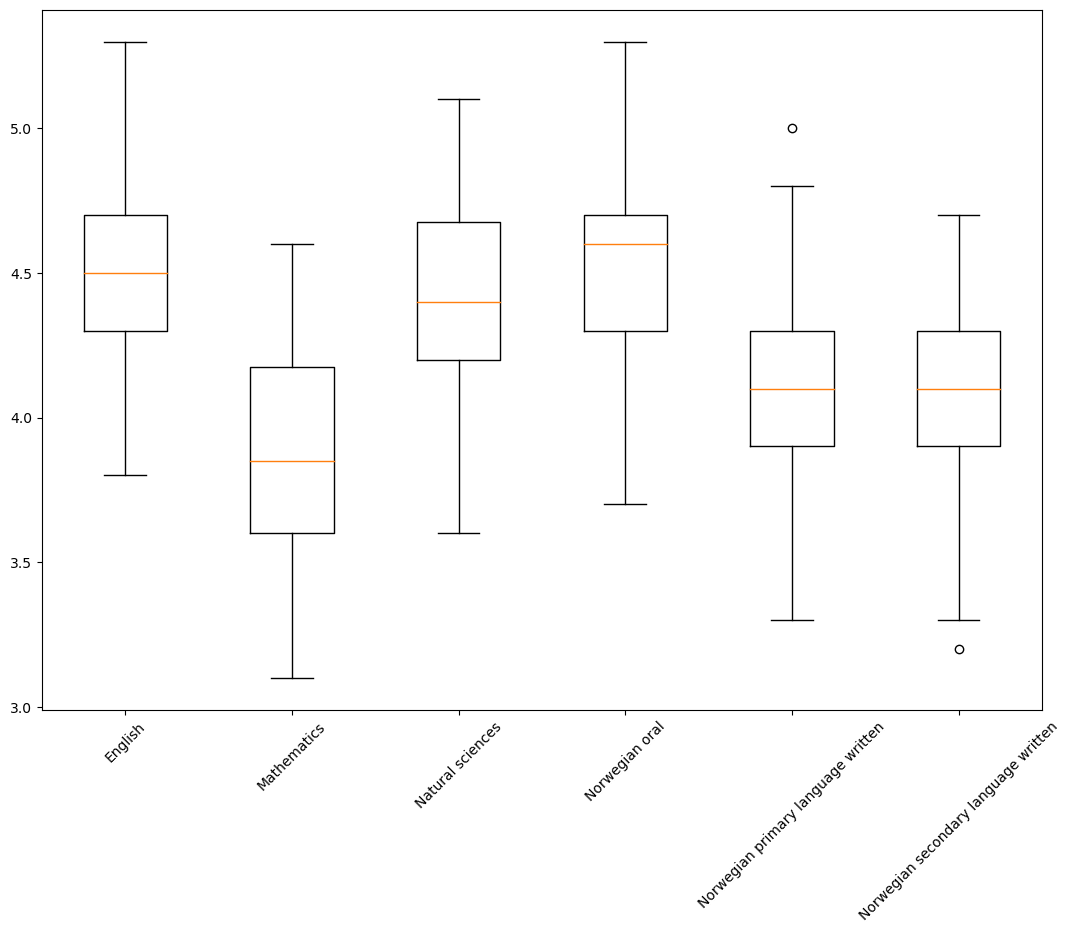

In [18]:
data_1 = df_piv['English']
data_2 = df_piv['Mathematics']
data_3 = df_piv['Natural sciences']
data_4 = df_piv['Norwegian oral']
data_5 = df_piv['Norwegian primary language written']
data_6 = df_piv['Norwegian secondary language written']
data = [data_1, data_2, data_3, data_4, data_5, data_6]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

ax.set_xticklabels(['English', 'Mathematics', 'Natural sciences',
                     'Norwegian oral', "Norwegian primary language written", "Norwegian secondary language written"])

plt.xticks(rotation = 45)

# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

# Comments on the box plot:
* From the box plot we can see that the median is somewhere between 3.8 and 4.6 on a grade scale that goes between 1 and 6. This implies that there are not big differences between the subjects and that they are comparable. This is helpful when we carry out a cluster analysis.
* In addition, the box plot show that most of the school have grade averages that are fairly close to the median.
* We can also see that there are only a few outliers. 

In [19]:
def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map
    adapted from https://stackoverflow.com/questions/39401729/plot-latitude-longitude-points-from-dataframe-on-folium-map-ipython'''
    
    folium.CircleMarker(location=[point[0], point[1]],
                        radius=2,
                        color="#E0970D",
                        weight=5).add_to(fig)

In [20]:
with open("data/Bydeler.geojson") as file:
    bydeler_geoJSON = json.load(file)

fig = folium.Map(location=[59.9100, 10.7258], zoom_start=11, tiles="Stamen Terrain")

fig.choropleth(
    geo_data=bydeler_geoJSON,
    fill_opacity=0
    )

for i in df_piv['Coordinates']:
    plotDot(i)

fig

In [21]:
fig.save("maps/1_oslo_schools.html")

# Comments on map:
* From the map we can see that all our schools are located within the city boundaries
* We can also see that the schools are evenly spaced across the whole city.
* Both these aspects indicate that the quality of our data is good.

<h1 style="font-size: 2.5em; background-color: #E0970D; padding: 1em">Cluster analysis</h1>

# Unsupervised learning - Cluster Analysis

* We will try out two types of clustering algorithms – kMeans and Hierarchical clustering.
* For both of these algorithms, we will try out models with two and three clusters. Based on our theories, we would expect that there are two to three clusters: two clusters if only one of the hypotheses are true and three clusters if both hypotheses are true.
* The hypotheses are true if the clusters follow the geographical pattern discussed above: The socio-economic hypothesis is true if we find one cluster in the east and one in the west and the immigration hypothesis is true if we find one cluster consisting of a oval shape stretching from the city center to the north east and a circle in the far south and another consisting of the remaining schools.
* Since there are no reason to expect more than three clusters, we will not try out four or more clusters. The cluster algorithms would surely find four or more clusters, but we would not be able to interpret them in any meaningful way.
* The main hyperparameter tuning that we carry out in this analysis is changing the number of clusters. Some initial experimentation with other hyperparameters led only to more “blurred” results and are therefore not included in the analysis
* We employ both kMeans and Hierarchical clustering to ensure that our results are robust. There are some discussions in the literature about the relative merits of the two techniques, but it is hard to say that one is superior in our analysis (see Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. (2013)). However, if we find that both techniques produce similar results, we can be more confident that our results are not accidental or a fluke.
* We will not scale the variables since all the subjects are on a scale from 1 to 6.

In [22]:
# Function to plot schools and their cluster categories

def plotDot(point, color):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map
    adapted from https://stackoverflow.com/questions/39401729/plot-latitude-longitude-points-from-dataframe-on-folium-map-ipython'''
    
    color_list = ['darkblue', 'darkred', 'orange']
    
    folium.CircleMarker(location=[point[0], point[1]],
                        radius=2,
                        color= color_list[color],
                        weight=5).add_to(fig)

<h1 style="font-size: 1.5em; background-color: #E0970D; padding: 1em">Kmeans with two clusters</h1>

In [23]:
from sklearn.cluster import KMeans
X = df_piv[ ['English', 'Mathematics', 'Natural sciences', 'Norwegian oral', 'Norwegian primary language written', 
             'Norwegian secondary language written'] ]
kmeans = KMeans(n_clusters=2).fit(X)

In [24]:
df_piv["Cluster 1"] = kmeans.labels_

In [25]:
with open("data/Bydeler.geojson") as file:
    bydeler_geoJSON = json.load(file)

fig = folium.Map(location=[59.9100, 10.7258], zoom_start=11, tiles="Stamen Terrain")

fig.choropleth(
    geo_data=bydeler_geoJSON,
    fill_opacity=0
    )

for i, e in zip(df_piv['Coordinates'], df_piv['Cluster 1']):
    plotDot(i, e)

fig

In [26]:
fig.save("maps/2_kmeans_2.html")

In [27]:
kmeans.cluster_centers_

array([[4.64848485, 4.12424242, 4.59393939, 4.71818182, 4.30909091,
        4.23636364],
       [4.268     , 3.488     , 4.156     , 4.252     , 3.8       ,
        3.844     ]])

In [28]:
index = ['English', 'Mathematics', 'Natural sciences', 'Norwegian oral', 
         'Norwegian primary language written', 'Norwegian secondary language written']

df = pd.DataFrame(zip(kmeans.cluster_centers_[0], kmeans.cluster_centers_[1]), columns = ['Blue', 'Red'], index=index)
df

Blue    Red
English                               4.648485  4.268
Mathematics                           4.124242  3.488
Natural sciences                      4.593939  4.156
Norwegian oral                        4.718182  4.252
Norwegian primary language written    4.309091  3.800
Norwegian secondary language written  4.236364  3.844

<h1 style="font-size: 1.5em; background-color: #E0970D; padding: 1em">Kmeans with three clusters</h1>

In [29]:
from sklearn.cluster import KMeans
X = df_piv[ ['English', 'Mathematics', 'Natural sciences', 'Norwegian oral', 'Norwegian primary language written', 
             'Norwegian secondary language written'] ]
kmeans = KMeans(n_clusters=3).fit(X)
df_piv["Cluster 2"] = kmeans.labels_

In [30]:
fig = folium.Map(location=[59.9100, 10.7258], zoom_start=11, tiles="Stamen Terrain")

fig.choropleth(
    geo_data=bydeler_geoJSON,
    fill_opacity=0
    )

for i, e in zip(df_piv['Coordinates'], df_piv['Cluster 2']):
    plotDot(i, e)

fig

In [31]:
fig.save("maps/3_kmeans_3.html")

In [32]:
index = ['English', 'Mathematics', 'Natural sciences', 'Norwegian oral', 
         'Norwegian primary language written', 'Norwegian secondary language written']

df = pd.DataFrame(zip(kmeans.cluster_centers_[0], kmeans.cluster_centers_[1], kmeans.cluster_centers_[2]), 
                  columns = ['Blue', 'Red', 'Orange'], index=index)
df.round(2)

Blue   Red  Orange
English                               4.40  4.72    4.18
Mathematics                           3.75  4.20    3.38
Natural sciences                      4.34  4.66    4.03
Norwegian oral                        4.50  4.78    4.05
Norwegian primary language written    4.02  4.41    3.62
Norwegian secondary language written  4.08  4.30    3.63

# Results from kMeans analysis

## 2 clusters
* A tendency towards blue labels on the west-side and red labels on the east-side. This add some support for the socio-economic hypothesis. 
* The blue cluster also has a higher-grade centroid than the red and thereby confirms the idea that the traditionally richer areas have higher grades.
* However, there are many cluster labels that are also inconsistent with the socio-economic hypothesis.

## 3 clusters
* Cluster result provide some support for both hypothesis I and II. The yellow labels are partially consistent with the immigration hypothesis and the red and blue are partially consistent withe socio-economic hypothesis.
* The yellow centroid is in general lower than the red and blue centroid, but is particularily low for the Norwegian subjects. This add some support to the immigration hypothesis. 
* The red and blue centroids follow the same eas-west-pattern as described above. 
* However, there are many cluster labels that are inconsistent with either one or both hypotheses  

<h1 style="font-size: 1.5em; background-color: #E0970D; padding: 1em">Hierarchical clustering with two clusters</h1>

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering


hierarchical_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(X)

In [34]:
df_piv["H Cluster 2"] = labels

In [35]:
fig = folium.Map(location=[59.9100, 10.7258], zoom_start=11, tiles="Stamen Terrain")

fig.choropleth(
    geo_data=bydeler_geoJSON,
    fill_opacity=0
    )

for i, e in zip(df_piv['Coordinates'], df_piv['H Cluster 2']):
    plotDot(i, e)

fig

In [36]:
fig.save("maps/4_hierarchical_2.html")

<h1 style="font-size: 1.5em; background-color: #E0970D; padding: 1em">Hierarchical clustering with three clusters</h1>

In [37]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(X)
df_piv["H Cluster 3"] = labels

In [38]:
fig = folium.Map(location=[59.9100, 10.7258], zoom_start=11, tiles="Stamen Terrain")

fig.choropleth(
    geo_data=bydeler_geoJSON,
    fill_opacity=0
    )

for i, e in zip(df_piv['Coordinates'], df_piv['H Cluster 3']):
    plotDot(i, e)

fig

In [39]:
fig.save("maps/5_hierarchical_3.html")

# Results from Hierarchical clustering
* Hierarchical clustering confirms the results from the kMean clustering

<h1 style="font-size: 2.5em; background-color: #E0970D; padding: 1em">Conclusion</h1>

The analysis found that ...
* there are some support for the two hypotheses,
* but that the reality is much more nuanced and complex, and the differences between the schools are in general quite small.

<h1 style="font-size: 2.5em; background-color: #E0970D; padding: 1em">References</h1>

Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. (2013). An introduction to statistical learning : with applications in R. New York :Springer